In [1]:
import os
import sys
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.tensorboard import SummaryWriter

## Settings

In [2]:
batch_size = 1
test_batch_size = 1
epochs = 4000
lr = 0.005
try_cuda = True
seed = 1000
logging_interval = 100 # how many batches to wait before logging


if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.mnaual_seed(seed)
else:
    cuda = False
    torch.manual_seed(seed)


writer = SummaryWriter(log_dir=f"runs/{datetime.now().strftime('%Y%m%d_%H%M%S')}")

## Data

In [3]:
tickers = ["AAPL", "NVDA", "AMD"]

def load_data(ticker):
    ticker = yf.Ticker(ticker)
    historical_data = ticker.history(period="10y")
    return (np.array(historical_data.Close) - np.array(historical_data.Open)) / np.array(historical_data.Open), np.array(historical_data.Volume) / historical_data.Volume.mean()


data = np.zeros((len(tickers), 2517))

for t, ticker in enumerate(tickers):
    returns, vol = load_data(ticker)
    data[t, :] = returns

train_points = 2000
trest_points = 516

X_train_tensor = torch.tensor(data[:, :2000], dtype=torch.float32).unsqueeze(0) 
y_train_tensor = torch.tensor(data[:, 1:2001], dtype=torch.float32).unsqueeze(0)
X_test_tensor = torch.tensor(data[:, 2000:-1], dtype=torch.float32).unsqueeze(0)
y_test_tensor = torch.tensor(data[:, 2001:], dtype=torch.float32).unsqueeze(0)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
X_train_tensor.shape

torch.Size([1, 3, 2000])

## Model

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=20, stride=1, padding=0)
        self.conv1_2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=20, stride=1, padding=0)

        self.conv2_1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=20, stride=1, padding=0)
        self.conv2_2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=20, stride=1, padding=0)

        self.conv3_1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=20, stride=1, padding=0)
        self.conv3_2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=20, stride=1, padding=0)
        
        self.fc1 = nn.Conv1d(in_channels=64 * 3, out_channels=128, kernel_size=1)
        self.fc2 = nn.Conv1d(in_channels=128, out_channels=3, kernel_size=1)

        self.apply(self.initialize_weights)

    def initialize_weights(self, module):
        if isinstance(module, nn.Conv1d):
            nn.init.normal_(module.weight) 
            if module.bias is not None:
                nn.init.normal_(module.bias)

        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight) 
            if module.bias is not None:
                nn.init.normal_(module.bias)

    def exponential_smoothing(self, x, alpha=0.3):
        # Apply exponential smoothing along the time dimension
        x_np = x.detach().cpu().numpy()
        smoothed = pd.DataFrame(x_np).ewm(alpha=alpha, axis=2).mean().values
        return torch.tensor(smoothed, dtype=torch.float32, device=x.device)

    def forward(self, x):
        x1 = x[:, 0:1, :]
        x1 = F.tanh(self.conv1_1(x1)) 
        x1 = F.tanh(self.conv1_2(x1))
        #x = self.exponential_smoothing(x, alpha=0.3)

        x2 = x[:, 1:2, :]
        x2 = F.tanh(self.conv2_1(x2)) 
        x2 = F.tanh(self.conv2_2(x2))

        x3 = x[:, 2:3, :]
        x3 = F.tanh(self.conv3_1(x3)) 
        x3 = F.tanh(self.conv3_2(x3))

        x_combined = torch.cat((x1, x2, x3), dim=1)
        #x_combined = x_combined.view(x_combined.size(0), -1)

        #x_combined = torch.cat((x1[:, :, -1], x2[:, :, -1], x3[:, :, -1]), dim=1)
        x = F.tanh(self.fc1(x_combined))
        x = self.fc2(x)
        #x = F.softmax(x, dim=1)

        return x


## Train

In [9]:
model = Net()

if cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()


def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target[:, :, -1962:])
        
        loss.backward()
        optimizer.step()

        if epoch % logging_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

            # Log train/loss to TensorBoard at every iteration
            n_iter = (epoch - 1) * len(train_loader) + batch_idx + 1
            writer.add_scalar('train/loss', loss.item(), n_iter)

    return output
            

## Run

In [10]:
# Training loop

for epoch in range(1, epochs + 1):
    o = train(epoch)

writer.close()

Train Epoch: 100 [0/1 (0%)]	Loss: 0.003592
Train Epoch: 200 [0/1 (0%)]	Loss: 0.001429
Train Epoch: 300 [0/1 (0%)]	Loss: 0.000932
Train Epoch: 400 [0/1 (0%)]	Loss: 0.000761
Train Epoch: 500 [0/1 (0%)]	Loss: 0.000688
Train Epoch: 600 [0/1 (0%)]	Loss: 0.000654
Train Epoch: 700 [0/1 (0%)]	Loss: 0.000635
Train Epoch: 800 [0/1 (0%)]	Loss: 0.000623
Train Epoch: 900 [0/1 (0%)]	Loss: 0.000614
Train Epoch: 1000 [0/1 (0%)]	Loss: 0.000608
Train Epoch: 1100 [0/1 (0%)]	Loss: 0.000603
Train Epoch: 1200 [0/1 (0%)]	Loss: 0.000599
Train Epoch: 1300 [0/1 (0%)]	Loss: 0.000596
Train Epoch: 1400 [0/1 (0%)]	Loss: 0.000594
Train Epoch: 1500 [0/1 (0%)]	Loss: 0.000592
Train Epoch: 1600 [0/1 (0%)]	Loss: 0.000590
Train Epoch: 1700 [0/1 (0%)]	Loss: 0.000588
Train Epoch: 1800 [0/1 (0%)]	Loss: 0.000587
Train Epoch: 1900 [0/1 (0%)]	Loss: 0.000586
Train Epoch: 2000 [0/1 (0%)]	Loss: 0.000585
Train Epoch: 2100 [0/1 (0%)]	Loss: 0.000584
Train Epoch: 2200 [0/1 (0%)]	Loss: 0.000584
Train Epoch: 2300 [0/1 (0%)]	Loss: 0.0005

0.0024288089317264384 -0.00047365978359367885


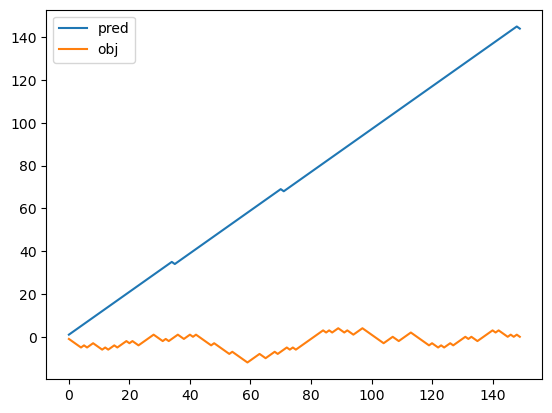

In [15]:
i = 2
pred = o[:, i, -150:][0].detach().cpu().numpy()
obj = y_train_tensor[:, i, -150:][0].detach().cpu().numpy()

exp = np.sqrt(np.dot(pred, pred) / len(pred))
real = (np.dot(pred, obj) / len(pred)) / exp

print(exp, real)

plt.plot(np.cumsum(pred), label="pred")
plt.plot(np.cumsum(obj), label="obj")

plt.legend()